In [79]:
import numpy as np
import cv2
import torch
import os
import matplotlib.pyplot as plt
import imutils
import emotion_classification.model as emotion_model
from PIL import Image
import numpy as np
import time
from keras.models import load_model
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [40]:
from keypoint_model import keypoint_model

In [41]:
def get_image(data_dir, file_name):
    path = os.path.join(data_dir, file_name)
    image = cv2.imread(path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [42]:
def get_classifier(data_dir, file_name):
    path = os.path.join(data_dir, file_name)
    classifier = cv2.CascadeClassifier(path)
    return classifier

In [43]:
def convert_image_to_bw(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = cv2.equalizeHist(image)
    return image

In [44]:
def detect_faces(classifier, image):
#     bw_image = convert_image_to_bw(image)
    rects = classifier.detectMultiScale(image, 1.2, 2)
#     for x, y, w, h in rects:
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return rects

In [45]:
def detect_keypoints(model, image, faces, padding = 50):
    image_copy = image.copy()
    img_height, img_width = image.shape[0], image.shape[1]
    images, keypoints = [], []
    for coords in faces:
#         img = image[max(0, coords[1]-padding): min(coords[1]+coords[-1]+padding, img_height), 
#                     max(0, coords[0]-padding): min(coords[0]+coords[2]+padding, img_width)]
        img = image[max(0, coords[1]): min(coords[1]+coords[-1], img_height), 
                    max(0, coords[0]): min(coords[0]+coords[2], img_width)]
#         img = (img/255.0).astype(np.float32)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
        img /= 255
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=0)
        else:
            img = np.rollaxis(img, 2, 0)
        img = np.expand_dims(img, axis=0)
        img = torch.from_numpy(img).type(torch.FloatTensor)
        results = model.forward(img)
        results = results.view(results.size()[0], 68, -1).cpu()
        pred = results[0].cpu().data
        pred = pred.numpy()
        pred = pred * 50 + 100
        keypoints.append(pred)
    return images, keypoints

In [46]:
model = keypoint_model()
model.load_state_dict(torch.load("./models/keypoint_detection_model.pth", map_location='cpu'))
model.eval()
classifier = get_classifier(data_dir="./models", file_name="face_detection_model.xml")

In [80]:
dog_filter = cv2.imread("filters/dog.png")
dog_filter_alt = cv2.imread("filters/dog_2.png")
haar_eyes = cv2.CascadeClassifier('./models/haarcascade_eye.xml')
sunglasses_filter = cv2.imread("filters/sunglasses.png", cv2.IMREAD_UNCHANGED)
flag_filter = cv2.imread("filters/flag.png", cv2.IMREAD_UNCHANGED)

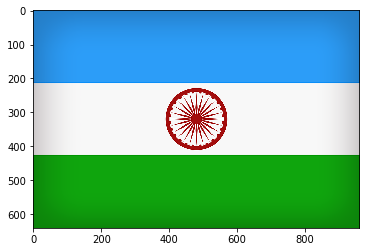

In [48]:
plt.imshow(flag_filter[:,:,:3])

In [49]:
def visualize_output(faces, test_outputs):  
    for i, face in enumerate(faces):
        plt.figure(figsize=(5, 5))
        plt.imshow(face)
        plt.scatter(test_outputs[i][:, 0], test_outputs[i][:, 1], s=20, marker='.', c='m')
        plt.axis('off')
    plt.show()

In [50]:
def overlay_filter_on_image(img, filt, off_x, off_y):
    (h,w) = (filt.shape[0], filt.shape[1])
    (imgH,imgW) = (img.shape[0], img.shape[1])
    if off_y+h >= imgH: 
        filt = filt[0:imgH-off_y,:,:]
    if off_x+w >= imgW:
        filt = filt[:,0:imgW-off_x,:]
    if off_x < 0:
        filt = filt[:,abs(off_x)::,:]
        w = filt.shape[1]
        off_x = 0
    for c in range(3):
        img[off_y:int(off_y+h), off_x:int(off_x+w), c] =  \
        filt[:,:,c] * (filt[:,:,3]/255.0) +  img[off_y:off_y+h, off_x:off_x+w, c] * (1.0 - filt[:,:,3]/255.0)
    return img

In [51]:
def get_part_filter(img, model,scale = 1.1, neighbors = 5, width = 30):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = model.detectMultiScale(
        gray,
        scaleFactor=scale,
        minNeighbors=neighbors,
        minSize=(width, width),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return features

In [52]:
def apply_sunglasses_filter(img, filt, part_filter, off_x, off_y, off_y_image, actual_width, x, y, w, h):
    (filt_h,filt_w) = (filt.shape[0], filt.shape[1])
    xpos = x + off_x
    ypos = y + off_y
    factor = 1.0 * actual_width/filt_w
    sub_img = img[y+off_y_image:y+h, x:x+w,:]
    feature = get_part_filter(sub_img, part_filter, 1.3 , 10, 10)
    if len(feature) != 0:
        xpos, ypos = x, y + feature[0,1]
    filt = cv2.resize(filt, (0,0), fx=factor, fy=factor)
    img = overlay_filter_on_image(img, filt, xpos, int(ypos))
    return img

In [53]:
def apply_flag_filter(frame, flag, keypts, face_loc):
    keypts = keypts[0]
#     keypts = np.array(keypts)
#     print(keypts.shape)
#     keypts[:,0], keypts[:,1] = keypts[:,0] * frame.shape[0]/224, keypts[:,1] * frame.shape[1]/224
#     keypts = keypts.tolist()

    #scale flag
    flag_height = int(abs(keypts[28][1] - keypts[30][1]))
    flag_width = int(abs(keypts[48][0] - keypts[54][0])/2)
    h,w,_ = flag.shape
    r = flag_height / float(h)
    dim = (int(w * r), flag_height)
    scaled_flag = cv2.resize(flag, dim, interpolation = cv2.INTER_AREA)
    print('dim', dim)
    
    #check and calculate rotation
    eyebrow_height_diff = abs(keypts[17][1] - keypts[26][1])
    eyebrow_width = abs(keypts[17][0] - keypts[26][0])
    eyebrow_angle = np.arctan(eyebrow_height_diff/eyebrow_width)*(180/np.pi)
    eyebrow_angle = eyebrow_angle if keypts[17][1] < keypts[26][1] else -eyebrow_angle
    new_flag = imutils.rotate_bound(scaled_flag, eyebrow_angle)
    b = (np.copy(new_flag))[:,:,:3]/255
    
    #translate and place flag
#     flag_x = int(face_loc[0] + keypts[35][0] + abs(keypts[33][0] - keypts[35][0])/2)
    flag_x = int(keypts[35][0] + abs(keypts[33][0] - keypts[35][0])*5/2)
    flag_y = int((keypts[33][0] + keypts[30][0])/2)
#     flag_x = int(keypts[28][0])
#     flag_y = int(keypts[28][1])
#     print(images[0].shape)
#     print(flag_width, flag_x)
#     print(frame.shape)
#     print(images[0][flag_y: flag_y + dim[1], flag_x: min(flag_x + dim[0], frame.shape[1])].shape)
    a = images[0][flag_y: flag_y + dim[1], flag_x: min(flag_x + dim[0], frame.shape[1])]
    a_copy = np.copy(a)
    a = a/255
    a = np.where(a < 0.5, 2*a*b, 1 - 2*(1-a)*(1-b)) * 255
    a = np.where(np.expand_dims(new_flag[:,:,3], axis=2) < 5, a_copy, a)
#     a = a*255
    images[0][flag_y: flag_y + dim[1], flag_x: min(flag_x + dim[0], frame.shape[1])] = a
    frame[face_loc[1]:face_loc[1] + face_loc[3], face_loc[0]: face_loc[0] + face_loc[2]] = cv2.resize(images[0], (face_loc[2], face_loc[3]), interpolation = cv2.INTER_AREA)
    return frame

In [54]:
def apply_dog_filter(face, filt):
    filt_h, filt_w, _ = filt.shape
    face_h, face_w, _ = face.shape
    factor = min(face_h/filt_h, face_w/filt_w)
    new_filt_h, new_filt_w = int(filt_h*factor), int(filt_w*factor)
    new_filt_shape = (new_filt_w, new_filt_h)
    resized_filter = cv2.resize(filt, new_filt_shape)
    masked_face = face.copy()
    non_white_pixels = (resized_filter < 250).all(axis = 2)
    offset_h, offset_w = int((face_h-new_filt_h)/2), int((face_w-new_filt_w)/2)
    masked_face[offset_h:offset_h+new_filt_h, offset_w:offset_w+new_filt_w][non_white_pixels] = resized_filter[non_white_pixels]
    return masked_face

In [55]:
def dog_face_filter(image, classifier, dog_filter):
    image_h, image_w = image.shape[0], image.shape[1]
    rectangles = detect_faces(classifier=classifier, image=image)
    for x, y, w, h in rectangles:
        y0, y1 = int(y - 0.25*h), int(y + 0.75*h)
        x0, x1 = x, x + w
        if x0 < 0 or y0 < 0 or x1 > image_w or y1 > image_h:
            continue
        image[y0: y1, x0: x1] = apply_dog_filter(image[y0: y1, x0: x1], dog_filter)
    return image

In [56]:
def get_emotion_predictor(model_path):
    net = emotion_model.Net().float().to(device)
    pretrained_model = torch.load(model_path, map_location='cpu')
    net.load_state_dict(pretrained_model)
    net.eval()
    return net

In [57]:
def emotion_predictor(emotion_classifier, image):
    image = convert_image_to_bw(image)
#     image = cv2.resize(image, (48, 48)).reshape((1, 1, 48, 48))
    image = cv2.resize(image, (48, 48)).reshape((1, 48, 48,1)).astype("float") / 255.0
#     X = torch.from_numpy(image).float().to(device)
    preds = emotion_classifier.predict(image)[0]
    emotion_probability = np.max(preds)
    return preds.argmax()
    return np.argmax(net(X).data.cpu().numpy(), axis=1)[0]

In [58]:
# dog_filtered_image = dog_face_filter(image.copy(), classifier, dog_filter)

In [59]:
net = emotion_model.Net().float().to(device)
emotion_model_path = 'emotion_classification/saved_models/best_emotion_model.pt'
net.load_state_dict(torch.load(emotion_model_path, map_location='cpu'))

In [60]:
ls emotion_classification/saved_models/

_mini_XCEPTION.37-0.63.hdf5  model_best.pth
best_emotion_model.pt


In [61]:
emotion_model_path_keras = 'emotion_classification/saved_models/_mini_XCEPTION.37-0.63.hdf5'
emotion_classifier = load_model(emotion_model_path_keras, compile=False)

In [83]:
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised",
 "neutral"]

In [62]:
# net = emotion_model.Net().float()
# pretrained_model = torch.load("emotion_classification/saved_models/model_best.pth")
# net.load_state_dict(pretrained_model['state_dict'])

In [91]:
cap = cv2.VideoCapture(0)
X = np.load('emotion_classification/data/fer2013_train.npz')['X'].reshape(-1, 1, 48, 48)
Y = np.load('emotion_classification/data/fer2013_train.npz')['Y']
idx_2 = np.where(Y == 2)[0][9]
X_idx_2 = np.squeeze(X[idx_2,:,:,:])
print(X_idx_2.shape)
while(True):
    emotion_detected = 0
    # Capture frame-by-frame
    ret, frame = cap.read()
#     frame = get_image(data_dir="./images", file_name="shock.jpg")
#     print(frame.shape)
#     frame = np.expand_dims(X_idx_2, axis=2)
#     cv2.imshow('', frame)
#     Our operations on the frame come here
    faces = detect_faces(classifier=classifier, image=frame)
    images, keypoints = detect_keypoints(faces=faces, image=frame, model=model, padding=50)
    if len(images) <= 0:
        continue
    x, y, w, h = faces[0]
#     try:
    emotion_detected = emotion_predictor(emotion_classifier, frame[faces[0][0]: faces[0][0]+faces[0][2], faces[0][1]:faces[0][1] + faces[0][3]])
#         emotion_detected = emotion_predictor(net, frame[faces[0][0]: faces[0][0]+faces[0][2], faces[0][1]:faces[0][1] + faces[0][3]])
#     emotion_detected = emotion_predictor(net, X_idx_2)
#     emotion_detected = 2
#     except:
#         pass
    print('Emotion Detected: ', emotion_detected)
    if emotion_detected == 3:   #happy
        filter_image = apply_sunglasses_filter(frame.copy(), sunglasses_filter, haar_eyes, 0, h/3, 0, w, x, y, w, h)
    elif emotion_detected == 4:  #sad
        filter_image = dog_face_filter(frame, classifier, dog_filter)
    elif emotion_detected == 5:  #surprised
        filter_image = apply_flag_filter(frame, flag_filter, keypoints, faces[0])
    else:
        filter_image = dog_face_filter(frame, classifier, dog_filter_alt)
    cv2.putText(filter_image, str(EMOTIONS[emotion_detected]), (int(filter_image.shape[1]/2), int(filter_image.shape[0]/2 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
#     Display the resulting frame
    time.sleep(0.3)
    cv2.imshow('frame',filter_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()



(48, 48)
Emotion Detected:  5
dim (28, 19)
Emotion Detected:  2
Emotion Detected:  2
Emotion Detected:  5
dim (28, 19)
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  5
dim (28, 19)
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  5
dim (28, 19)
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  6
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  4
Emotion Detected:  3
Emotion Detected:  3
Emotion Detected:  3
Emotion Detected:  4
Emotion Detected:  3
Emotion Detected:  4
Emotion Detected:  2


In [90]:
cap.release()
cv2.destroyAllWindows()

In [48]:
X = np.load('emotion_classification/data/fer2013_train.npz')['X'].reshape(-1, 1, 48, 48)
# print(X.shape)
Y = np.load('emotion_classification/data/fer2013_train.npz')['Y']
# idx_0 = np.where(Y == 0)[0][0]
# print(idx_0)
# idx_1 = np.where(Y == 1)[0][0]
idx_2 = np.where(Y == 2)[0][9]
# X_idx_0 = np.squeeze(X[idx_0,:,:,:]) # happy
# X_idx_1 = np.squeeze(X[idx_1,:,:,:]) # sad
X_idx_2 = np.squeeze(X[idx_2,:,:,:]) # shock/surprise
# plt.imshow(X_idx_2) 
len(np.where(Y == 1)[0])

4843

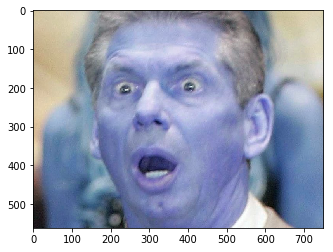

In [31]:
shock = cv2.imread('images/shock.jpg')
plt.imshow(shock)

In [ ]:
(min(flag_width, frame.shape[1]-flag_x)
(flag_width, int(flag_shape[0]*flag_width/flag_shape[1])

(400, 320, 3)


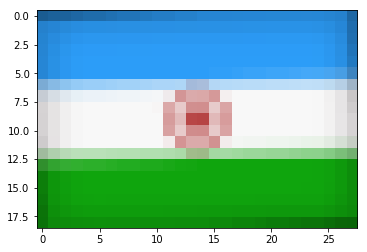

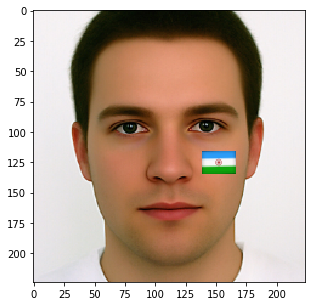

In [31]:
flag = flag_filter
plt.imshow(flag)
frame = get_image(data_dir="./images", file_name="face.jpg")
print(frame.shape)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = detect_faces(classifier=classifier, image=frame)
images, keypoints = detect_keypoints(faces=faces, image=frame, model=model, padding=50)
# print(keypoints)
keypoints = keypoints[0]
# keypoints = np.array(keypoints)

# print(faces[0])
# print(keypoints.shape)
# keypoints[:,0], keypoints[:,1] = (keypoints[:,0] * frame.shape[1]/faces[0][2]), (keypoints[:,1] * frame.shape[0]/faces[0][3])
# keypoints[:,0], keypoints[:,1] = (keypoints[:,0] * frame.shape[1]/faces[0][2]), (keypoints[:,1] *
# keypoints = keypoints.tolist()
# print(keypoints)
#scale flag
flag_height = int(abs(keypoints[28][1] - keypoints[30][1]))
flag_width = int(abs(keypoints[48][0] - keypoints[54][0])/2)
h,w,_ = flag_filter.shape
r = flag_height / float(h)
dim = (int(w * r), flag_height)
scaled_flag = (cv2.resize(flag_filter, dim, interpolation = cv2.INTER_AREA))
#check and calculate rotation
eyebrow_height_diff = abs(keypoints[17][1] - keypoints[26][1])
eyebrow_width = abs(keypoints[17][0] - keypoints[26][0])
eyebrow_angle = np.arctan(eyebrow_height_diff/eyebrow_width)*(180/np.pi)
eyebrow_angle = eyebrow_angle if keypoints[17][1] < keypoints[26][1] else -eyebrow_angle
# scaled_flag = cv2.resize(flag, (flag_width, flag_height), interpolation = cv2.INTER_CUBIC)
new_flag = imutils.rotate_bound(scaled_flag, eyebrow_angle)

flag_x = int(keypoints[35][0] + abs(keypoints[33][0] - keypoints[35][0])*3/2)
flag_y = int((keypoints[33][0] + keypoints[30][0])/2)

images[0][flag_y: flag_y + dim[1], flag_x: min(flag_x + dim[0], frame.shape[1])] = new_flag.astype(int)/255
# print(images[0][flag_y: flag_y + dim[1], flag_x: min(flag_x + dim[0], frame.shape[1])])

plt.imshow(new_flag)
idx = list(range(len(keypoints)))
plt.figure(figsize=(5, 5))
plt.imshow(images[0])
# for i in idx:
#     plt.scatter(keypoints[i][0], keypoints[i][1], s=20, marker='.', c='m')
#     plt.annotate(i+1, xy=(keypoints[i][0], keypoints[i][1]), xytext=(5, 2), textcoords='offset points', ha='right', color='red', va='bottom')
# plt.axis('off')
cv2.imshow('frame',images[0])
if cv2.waitKey(1) & 0xFF == ord('q'):
    cv2.destroyAllWindows()
plt.show()

In [109]:
flag_filter = np.array(plt.imread("filters/flag.png"))
h,w,_ = flag_filter.shape
r = flag_height / float(h)
dim = (int(w * r), flag_height)
print(flag_filter.shape)
print(flag_width, flag_height)
scaled_flag = (cv2.resize(flag_filter, dim, interpolation = cv2.INTER_AREA))
new_flag = imutils.rotate_bound(scaled_flag, eyebrow_angle)
plt.imsave('save.jpg',new_flag)

(640, 960, 4)
21 19


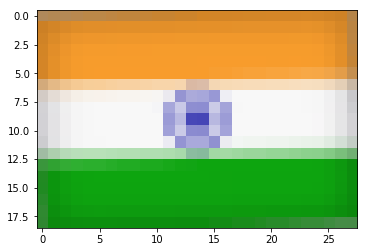

In [110]:
plt.imshow(new_flag)

In [26]:
pwd

'/Users/jugatsinghlamba/Code/face_filters1/pipeline'